# Functions for Helping Translate Results to Real Observations

In [1]:
# all we need is numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# These are just preferences for making plots
# If you are getting errors from matplotlib, feel free to comment this out
plt.rc('font', **{'size': 8, 'sans-serif': ['Helvetica'], 'family': 'sans-serif'})
plt.rc('legend',**{'fontsize':6})                                             
plt.rc("text.latex", preamble=[
    "\\usepackage[T1]{fontenc}\\usepackage{amsmath}"])
plt.rc("text", usetex=True)
plt.rc('ps', usedistiller='xpdf')
plt.rc('savefig', **{'dpi': 300})

In [3]:
# First setting the range of metallicities and ages that are covered, these are our default values
metlist = np.array([0.5,0.25,0.0,-0.25,-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0,-2.25,-2.5,-2.75,-3.,-3.25])
agelist = np.array([8.95,9.,9.05,9.1,9.15,9.2,9.25,9.3,9.35,9.4,9.45,9.5,9.55,9.6,9.65,9.7,9.75,9.8,9.85,9.9,9.95,10.,10.05,10.1])
nmet  = len(metlist)
nage  = len(agelist)

In [4]:
# for MIST
nfilt = 7
filter_names = np.array([r"$F062/R$",r"$F087/Z$",r"$F106/Y$",r"$F129/J$",r"$F146/W$",r"$F158/H$",r"$F184$"])
# for Padova
#nfilt = 8
#filter_names = np.array([r"$F062/R$",r"$F087/Z$",r"$F106/Y$",r"$F129/J$",r"$F146/W$",r"$F158/H$",r"$F184$",r"$F213/K_s$"])

In [5]:
## For MIST
## Order here is F062, F087, F106, F129, F146, F158, F184
ps_detect_5slim = np.array([27.8, 27.5, 27.4, 27.3, 27.6, 27.3, 26.8])

## For Padova
## Order here is F062, F087, F106, F129, F146, F158, F184, F213/Ks
#ps_detect_5slim = np.array([27.8, 27.5, 27.4, 27.3, 27.6, 27.3, 26.8, 25.5])

In [6]:
## for MIST
## Here is the f_det file
fdet = np.load("data/fdet_mist.npy")
## The average luminosity file
lum = np.load("data/lum_mist.npy")
## And the Second luminosity moment file
L2 = np.load("data/l2_mist.npy")

## for Padova
## Here is the f_det file
#fdet = np.load("data/fdet_padova.npy")
## The average luminosity file
#lum = np.load("data/lum_padova.npy")
## And the Second luminosity moment file
#L2 = np.load("data/l2_padova.npy")

Okay, we've loaded them, now we want to assure that they have the right shapes. The shape of $f_{\rm det}$ should be (nmet, nage, nmags, nfilt + 1) where nmags is the number of limiting magnitudes that we calculated for, which we will allow to be determined by the shape of fdet itself, and then check for consistency.

In [7]:
# the limiting magnitudes that fdet was calculated for should take up 
# the "first" slot in the filter dimension. It's the same for every population
# and filter, so there's a lot of repeated information
nmags = fdet.shape[2]
Mags = fdet[0,0,:,0]

In [8]:
# check that fdet is the correct shape
print("These should be the same: (%d, %d, %d, %d)"%(nmet,nage,nmags,nfilt+1),fdet.shape)

These should be the same: (16, 24, 100, 8) (16, 24, 100, 8)


In [9]:
# The shape of lum should be (nmet, nage, nfilt)
print("These should be the same: (%d, %d, %d)"%(nmet,nage,nfilt),lum.shape)

These should be the same: (16, 24, 7) (16, 24, 7)


In [10]:
# The shape of L2 should be (nmet, nage, nfilt, nmags)
print("These should be the same: (%d, %d, %d, %d)"%(nmet,nage,nfilt,nmags),L2.shape)

These should be the same: (16, 24, 7, 100) (16, 24, 7, 100)


In [11]:
sigm = 0.01 # photometric precision of measurement in magnitudes
ares = (0.1)**2 # psf area in square arceseconds (assumed top hat) this should really vary with filter

In [12]:
# function for getting the final term in Equation 6 of our paper
def get_olsen_term(sigmaB,A,Bcut,Lavg,l2_Mags,l2):
    # interpolate the l2 values calculated for a range of limiting 
    # absolute magnitudes on to the limiting absolute magnitudes
    # calculated here
    L2_interp = np.interp(Bcut,l2_Mags[::-1],l2[::-1])
    # calculate the last term in Equation 8 in our paper
    return 2.5*np.log10(((sigmaB/1.086)**2)*(Lavg)/(A*L2_interp))

# function for determining the magnitude that we *can* get the 
# photometry of accurately if we are in the crowding limited 
# regime by interpolating
def get_Mcrowd(S,d,mi,aj,fk):
    # calculate distance modulus
    mu = 25 + 5*np.log10(d)
    # get the limiting magnitudes to check
    Mags = fdet[mi,aj,:,0]
    # get the olsen terms to interpolate between
    ols_terms = get_olsen_term(sigm,ares,Mags,lum[mi,aj,fk],fdet[mi,aj,:,0],L2[mi,aj,fk])
    # define the crowding limited surface brightness as a function 
    # of limiting magnitude of the observation
    lim_sb = 2*Mags + mu - ols_terms
    # interpolate the correct limiting magnitude based on when the 
    # surface brightness limit would be reached
    res = np.interp(S,lim_sb[::-1],Mags[::-1])
    return res
    
# function for getting the expected number of stars per square 
# arcsecond over some constant surface brightness area, also 
# returns whether or not the crowding limit has been reahed
def getndet_singleSurf(S, d, texp, mi, aj, fk):
    # args S = surface brightness in this grid
    #      others are as below
    # calculate distance modulus
    mu = 25 + 5*np.log10(d)
    # and limiting magnitude
    Mlim = ps_detect_5slim[fk] - mu + 1.25*np.log10(texp/1e3)
    # total number density of stars
    ntot_here = 10**((S-mu)/-2.5)/lum[mi,aj,fk]
    # fraction of stars that are detected
    fdet_here = np.interp(Mlim,fdet[mi,aj,:,0][::-1],fdet[mi,aj,:,fk+1][::-1])

    # determine whether we are past the crowding limit in surface brightness
    ols_fac = get_olsen_term(sigm,ares,Mlim,lum[mi,aj,fk],fdet[mi,aj,:,0],L2[mi,aj,fk])
    # this is our limiting surface brightness for
    # crowding as a function of exposure time
    lso =  2*Mlim + mu - ols_fac
    crowded = lso>S
    if crowded:
        # if the region is crowded, we calculate the magnitude limit that it 
        # would not be crowded for and then the number of those stars that 
        # we end up detecting
        Mcrowd = get_Mcrowd(S,d,mi,aj,fk)
        fdet_crowd = np.interp(Mcrowd,fdet[mi,aj,:,0][::-1],fdet[mi,aj,:,fk+1][::-1])
        return (1.0,ntot_here*fdet_crowd)
    else:
        return (0.0,ntot_here*fdet_here)

# function for getting the expected number of resolved stars
# across a grid of surface brightness for a single age and 
# metallicity population at a given distance in a single band
# also returns map of where the observation is crowding limited
def getN_gridSurf(surfGrid, ang, d, texp, mi, aj, fk):
    # args surfGrid = square grid of surface brightnesses
    #      ang      = angular scale of one side of grid in arcsec
    #      d        = distance to population in Mpc
    #      texp     = exposure time in seconds
    #      mi       = metallicity index
    #      aj       = age index
    #      fk       = filter index
    # make sure that the grid is the right shape
    assert(len(surfGrid.shape)==2)
    assert(surfGrid.shape[0]==surfGrid.shape[1])
    # determine sky area of each cell in grid
    Nside = surfGrid.shape[0]
    area_sqarc = (ang/Nside)**2
    Nres = 0.0
    # create map to indicate where observation is crowded
    crowd_map = np.zeros(surfGrid.shape).flatten()
    for (j,surf) in enumerate(surfGrid.flatten()):
        (crowd,nhere) = getndet_singleSurf(surf,d,texp,mi,aj,fk)
        crowd_map[j] = crowd
        Nres += area_sqarc*nhere
    return (crowd_map.reshape(surfGrid.shape),Nres)

# a function to give you the surface brightness in another
# band given the surface brightness in some band and the 
# properties of the population
def convert_Sigma(surfIn,f_in,f_out,mi,aj):
    # args surfIn = surface brightness in reference band
    #      f_in   = index of reference filter
    #      f_out  = index of desired filter out
    #      mi     = metallicity index
    #      aj     = age index
    return surfIn - 2.5*np.log10(lum[mi,aj,f_out]/lum[mi,aj,f_in])

In [20]:
def cenA_surf(r):
    ## parameters for a surface brightness profile of CenA
    # halo, made "by-eye" from Fig. 9 of Crnojevic et al. 2016
    # this is surface brightness in the r-band
    (Sa,ra,Sb,rb) = (27,60,32,420)
    m = (Sb-Sa)/(rb-ra)
    b = Sa - m*ra
    Slin = m*r+b

    Llin = 10**(Slin/-2.5)
    S2 = -2.5*np.log10(Llin + 10**(30/-2.5))
    return S2
    
def ngc4244_surf(r):
    # source is radburn-smith et al. 2011 Fig. 3
    # gives surface brightness in AB z band
    # r should be in. units of arcsec
    # ouput is mags/square arcsecond
    return (21 + (3.5/425)*r)*(r<425) + (r>=425)*(13.68 + 0.02545*r)

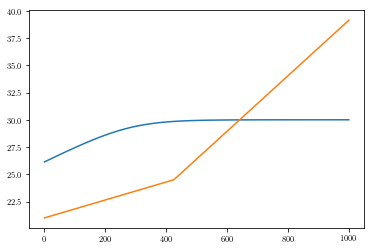

In [23]:
rlin = np.linspace(0,1000,100)

plt.plot(rlin,cenA_surf(rlin))
plt.plot(rlin,ngc4244_surf(rlin))

In [ ]:
meti = 10
agej = 22
filtk = 5
dist = 10
dmod = 25 + 5*np.log10(dist)
expts = np.logspace(1,5,100)
Mlim = ps_detect_5slim[filtk] - dmod + 1.25*np.log10(expts/1e3)
ols_fac = get_olsen_term(sigm,ares,Mlim,lum[meti,agej,filtk],fdet[meti,agej,:,0],L2[meti,agej,filtk])
lso = 2*Mlim + dmod - ols_fac
print(get_Mcrowd(32,dist,meti,agej,filtk))
plt.plot(expts,lso)
plt.xscale("log")

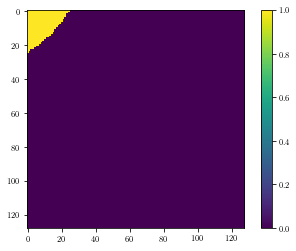

In [16]:
N = 128
ang_size = 450 # length of one RST detector in arcsecond
# define center of observation relative to some surface brightness profile
(x0,y0) = (360,360)
xlin = np.linspace(-ang_size/2,ang_size/2,N)
(xs,ys) = np.meshgrid(xlin,xlin)
# allow for field to be rotated
theta_deg = 0. #angle to rotate field by in degrees
theta_rad = theta_deg*(np.pi/180) #angle to rotate field by in radians
xnew = np.cos(theta_rad)*xs - np.sin(theta_rad)*ys
ynew = np.sin(theta_rad)*xs + np.cos(theta_rad)*ys

xs = xnew + x0
ys = ynew + y0
rs = np.sqrt(xs**2 + ys**2)
Surf = np.interp(rs,rlin,S2)

Nout = []
for i in range(nfilt):
    Nout.append(getN_gridSurf(convert_Sigma(Surf,0,i,10,22),ang_size,4.61,50,10,22,0)[1])

plt.imshow(getN_gridSurf(Surf,ang_size,4.61,50,10,22,0)[0],vmin=0,vmax=1)
#plt.imshow(Surf)
plt.colorbar()

[Text(0, 0, 'R'),
 Text(0, 0, 'Z'),
 Text(0, 0, 'Y'),
 Text(0, 0, 'W'),
 Text(0, 0, 'J'),
 Text(0, 0, 'H'),
 Text(0, 0, 'F')]

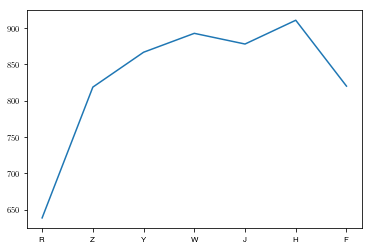

In [19]:
ax = plt.subplot(111)
ax.plot(Nout)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(['R','Z','Y','W','J','H','F'])

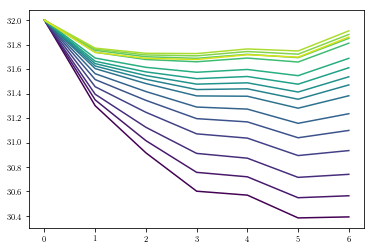

In [23]:
# Your code goes here!
agej = 22
Sigma = 32 # in mag/arcsec^2
d = 10 # in Mpc
for meti in range(len(metlist)):

    sigmas = np.array([Sigma,convert_Sigma(Sigma,0,1,meti,agej),convert_Sigma(Sigma,0,2,meti,agej),\
                       convert_Sigma(Sigma,0,3,meti,agej),convert_Sigma(Sigma,0,4,meti,agej),
                       convert_Sigma(Sigma,0,5,meti,agej),convert_Sigma(Sigma,0,6,meti,agej)])

    plt.plot(sigmas,c=plt.cm.viridis(meti*1./len(metlist)))
#plt.plot(ps_detect_5slim+4.2)